In [2]:
import pandas as pd

ini_data = pd.ExcelFile('DATA_VKR_FIN.xlsx')
qual = ini_data.parse('Qualitative_data (с нулями)')
qual.drop(['№', 'Year', 'Name'], axis=1, inplace=True)
qual = qual.rename(columns={"Default": "target"}) #target = дефолт (1 или 0)
qual

,target,Comp_age,Corp_group,Courts,Audit_qual,Adress,Ind_innov,Competition,M_founder,Discl_lev,Man_change,Is_Europe,Is_Asia,Is_service,Is_JointStock,Is_SME,Is_LLC
0,0,22.5,10,0,10.0,0,10,1.0,0,1,0,10,0,0,10,0,0
1,0,23.5,10,0,10.0,0,7,1.0,0,1,0,10,0,0,10,0,0
2,0,24.5,10,0,10.0,0,10,1.0,0,1,0,10,0,0,10,0,0
3,0,25.5,10,1,10.0,0,10,1.0,0,1,0,10,0,0,10,0,0
4,0,26.5,10,0,10.0,0,10,1.0,0,1,0,10,0,0,10,0,0
5,0,14.0,10,0,10.0,0,4,2.5,0,1,0,0,0,10,0,0,10
6,0,15.0,10,1,10.0,0,1,2.5,0,1,0,0,0,10,0,0,10
7,0,16.0,10,1,10.0,0,1,1.0,0,1,0,0,0,10,0,0,10
8,0,17.0,10,1,10.0,0,1,2.5,0,1,0,0,0,10,0,0,10
9,0,18.0,10,1,10.0,0,1,1.0,0,1,0,0,0,10,0,0,10


In [3]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [4]:
qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 17 columns):
target           885 non-null int64
Comp_age         885 non-null float64
Corp_group       885 non-null int64
Courts           885 non-null int64
Audit_qual       885 non-null float64
Adress           885 non-null int64
Ind_innov        885 non-null int64
Competition      885 non-null float64
M_founder        885 non-null int64
Discl_lev        885 non-null int64
Man_change       885 non-null int64
Is_Europe        885 non-null int64
Is_Asia          885 non-null int64
Is_service       885 non-null int64
Is_JointStock    885 non-null int64
Is_SME           885 non-null int64
Is_LLC           885 non-null int64
dtypes: float64(3), int64(14)
memory usage: 117.6 KB


In [5]:
qual['target'].value_counts()

0    605
1    280
Name: target, dtype: int64

In [6]:
final_iv, IV = data_vars(qual,qual.target)

In [7]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Comp_age,0.0,9.5,296,182,0.614865,114,0.385135,0.650000,0.188430,1.238247,0.984829
1,Comp_age,10.0,16.0,304,59,0.194079,245,0.805921,0.210714,0.404959,-0.653282,0.984829
2,Comp_age,16.5,29.0,285,39,0.136842,246,0.863158,0.139286,0.406612,-1.071331,0.984829
3,Corp_group,0.0,0.0,356,176,0.494382,180,0.505618,0.628571,0.297521,0.747966,0.458580
4,Corp_group,10.0,10.0,529,104,0.196597,425,0.803403,0.371429,0.702479,-0.637259,0.458580
5,Courts,0.0,0.0,554,179,0.323105,375,0.676895,0.639286,0.619835,0.030899,0.001623
6,Courts,1.0,1.0,331,101,0.305136,230,0.694864,0.360714,0.380165,-0.052520,0.001623
7,Audit_qual,0.0,1.0,130,108,0.830769,22,0.169231,0.385714,0.036364,2.361528,0.982298
8,Audit_qual,1.9,10.0,755,172,0.227815,583,0.772185,0.614286,0.963636,-0.450254,0.982298
9,Adress,0.0,0.0,852,272,0.319249,580,0.680751,0.971429,0.958678,0.013213,0.004873


In [8]:
IV.sort_values('IV')

,VAR_NAME,IV
5,Courts,0.001623
0,Adress,0.004873
6,Discl_lev,0.008298
10,Is_JointStock,0.012155
15,Man_change,0.038829
8,Is_Asia,0.040642
14,M_founder,0.062901
3,Competition,0.070492
7,Ind_innov,0.090500
12,Is_SME,0.149360


In [9]:
# удаляем поля с бесполезными и слабыми переменными на основе критерия IV
qual = qual.drop(['Courts', 'Is_JointStock', 'Adress', 'Discl_lev'], axis = 1)
qual.head()

,target,Comp_age,Corp_group,Audit_qual,Ind_innov,Competition,M_founder,Man_change,Is_Europe,Is_Asia,Is_service,Is_SME,Is_LLC
0,0,22.5,10,10.0,10,1.0,0,0,10,0,0,0,0
1,0,23.5,10,10.0,7,1.0,0,0,10,0,0,0,0
2,0,24.5,10,10.0,10,1.0,0,0,10,0,0,0,0
3,0,25.5,10,10.0,10,1.0,0,0,10,0,0,0,0
4,0,26.5,10,10.0,10,1.0,0,0,10,0,0,0,0


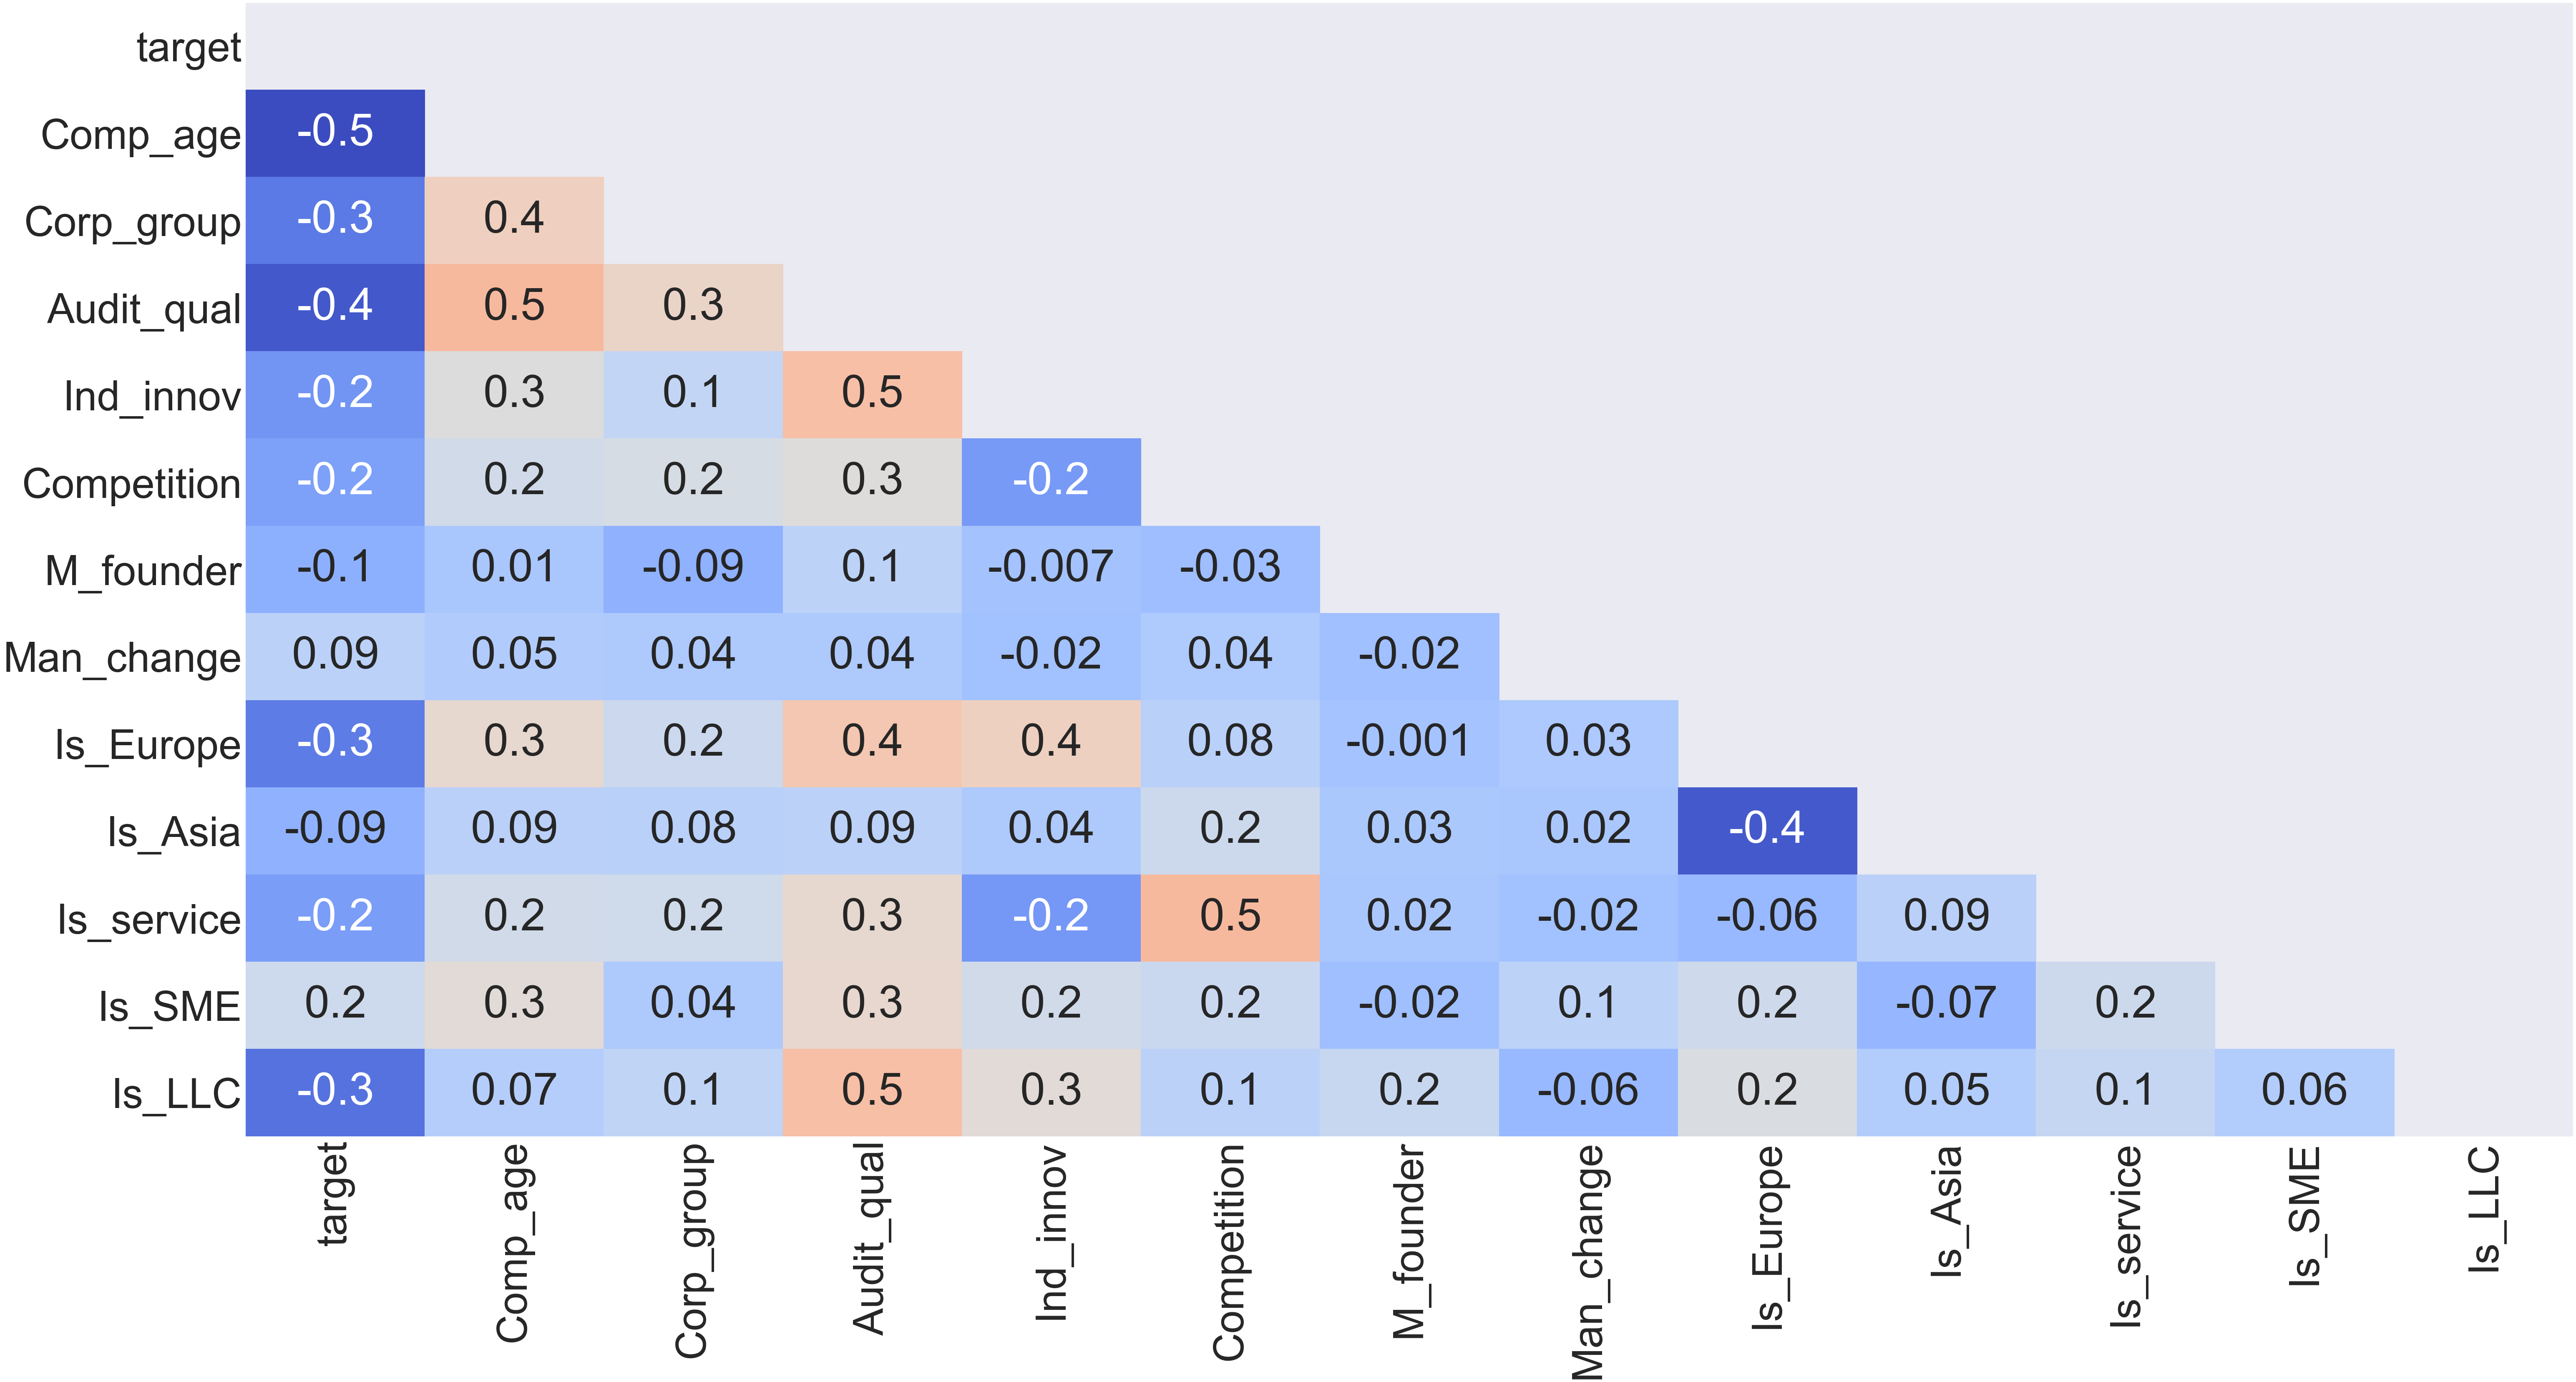

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(font_scale=9)
f, ax = plt.subplots(figsize=(100, 50))
matrix = np.triu(qual.corr(method='pearson'))
sns.heatmap(qual.corr(method='pearson'), annot=True, mask=matrix, cbar = False, fmt = '.1g', cmap= 'coolwarm')

In [12]:
qual = qual.drop(['Audit_qual', 'Competition'], axis = 1)
qual.head()

,target,Comp_age,Corp_group,Ind_innov,M_founder,Man_change,Is_Europe,Is_Asia,Is_service,Is_SME,Is_LLC
0,0,22.5,10,10,0,0,10,0,0,0,0
1,0,23.5,10,7,0,0,10,0,0,0,0
2,0,24.5,10,10,0,0,10,0,0,0,0
3,0,25.5,10,10,0,0,10,0,0,0,0
4,0,26.5,10,10,0,0,10,0,0,0,0


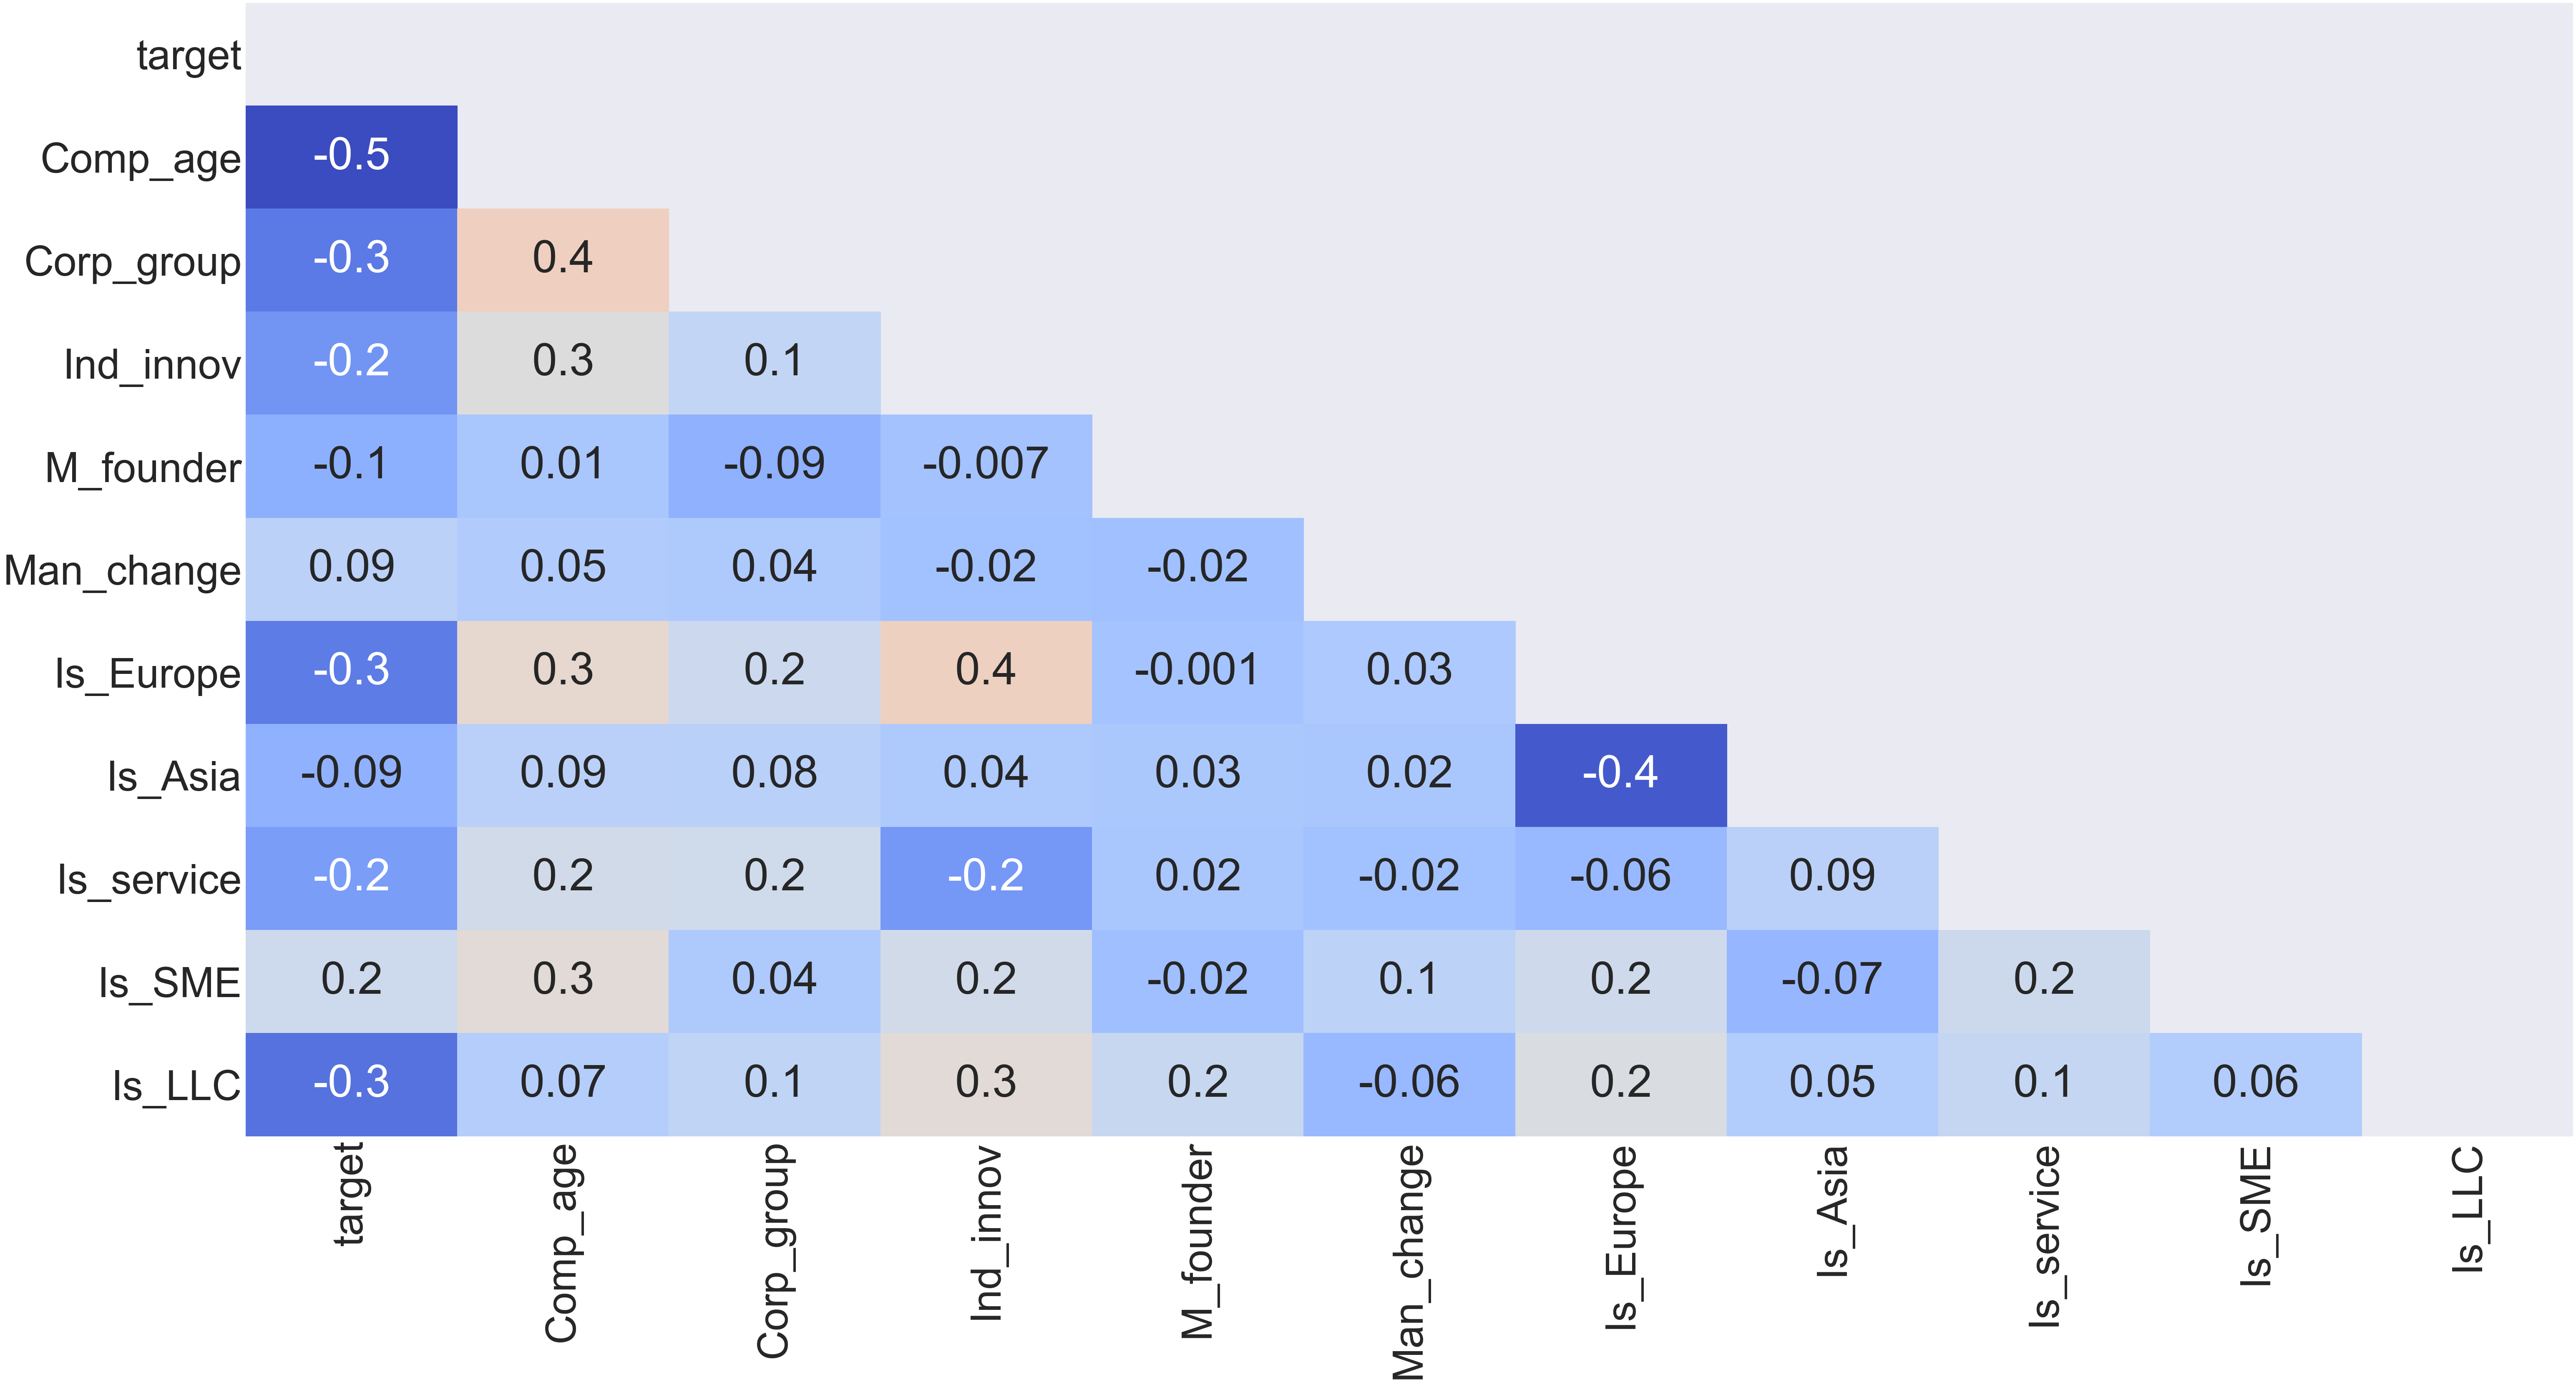

In [13]:
sns.set(font_scale=9)
f, ax = plt.subplots(figsize=(100, 50))
matrix = np.triu(qual.corr(method='pearson'))
sns.heatmap(qual.corr(method='pearson'), annot=True, mask=matrix, cbar = False, fmt = '.1g', cmap= 'coolwarm')